# Next-frame prediction with Conv-LSTM

**Author:** [jeammimi](https://github.com/jeammimi)<br>
**Date created:** 2016/11/02<br>
**Last modified:** 2020/05/01<br>
**Description:** Predict the next frame in a sequence using a Conv-LSTM model.

Not working with 3D wedge dropout ???
Try LSTM2D

ALso, port to TPU since it's synthetic data.

## Introduction

This script demonstrates the use of a convolutional LSTM model.
The model is used to predict the next frame of an artificially
generated movie which contains moving squares.


## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt


## Build a model

We create a model which take as input movies of shape
`(n_frames, width, height, channels)` and returns a movie
of identical shape.


In [2]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        # layers.SpatialDropout3D(0.2),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta", metrics=['acc'])


## Generate artificial data

Generate movies with 3 to 7 moving squares inside.
The squares are of shape 1x1 or 2x2 pixels,
and move linearly over time.
For convenience, we first create movies with bigger width and height (80x80)
and at the end we select a 40x40 window.


In [3]:

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies



## Train the model


In [4]:
epochs = 2
patience = 1
tf.random.set_seed(42)

earlystopping = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, min_delta=1e-3)

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
history = seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=30,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
    callbacks=[earlystopping]
)
print('Eval validation:', history.history['val_loss'][-patience], history.history['val_acc'][-patience])

Epoch 1/2
30/30 - 47s - loss: 0.8051 - acc: 0.5519 - val_loss: 0.6931 - val_acc: 0.5797
Epoch 2/2
30/30 - 25s - loss: 0.7893 - acc: 0.5727 - val_loss: 0.6924 - val_acc: 0.6769
Eval validation: 0.6924199461936951 0.6768670678138733


## Test the model on one movie

Feed it with the first 7 positions and then
predict the new positions.


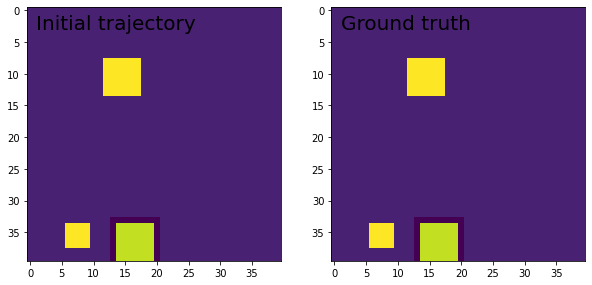

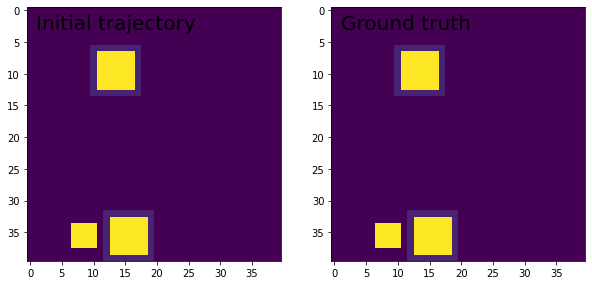

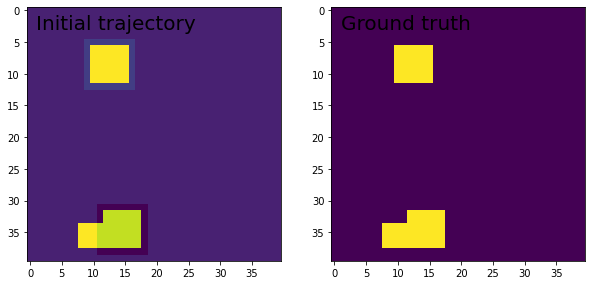

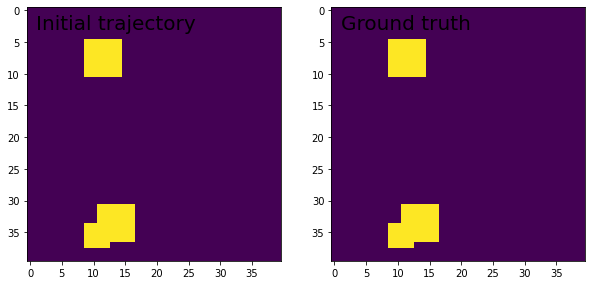

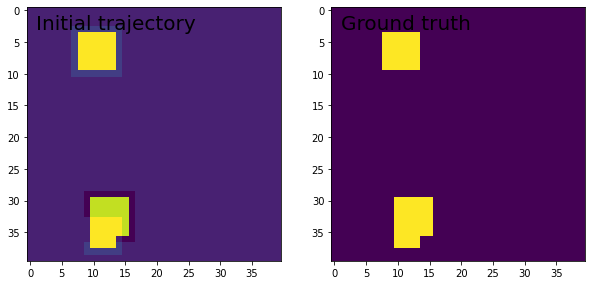

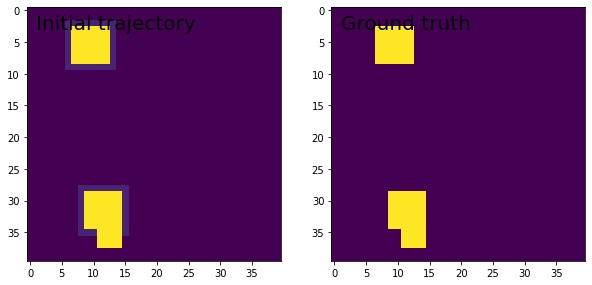

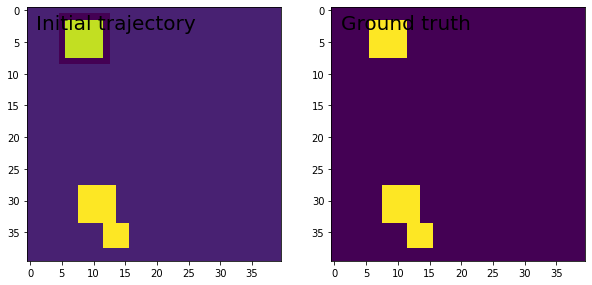

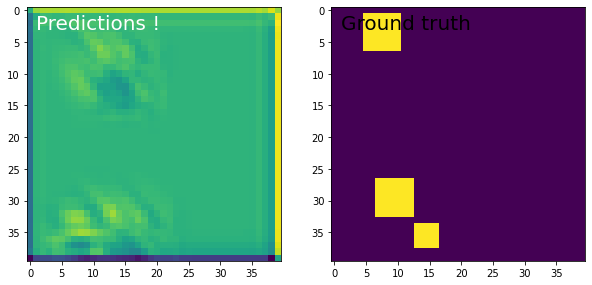

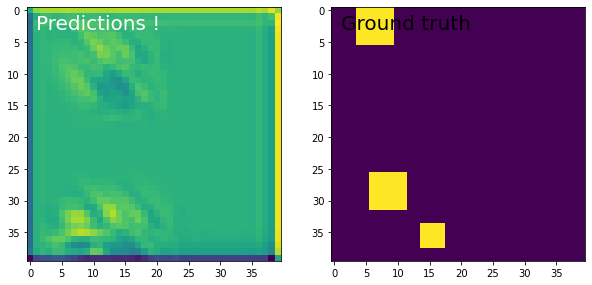

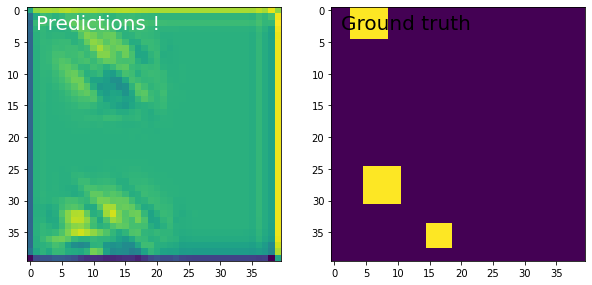

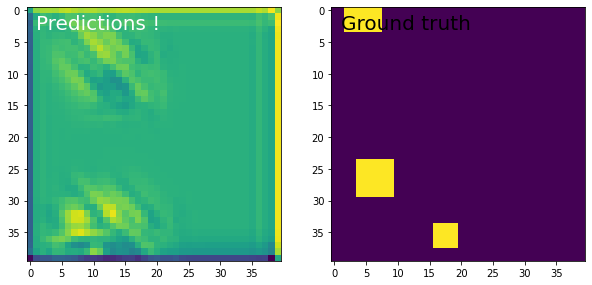

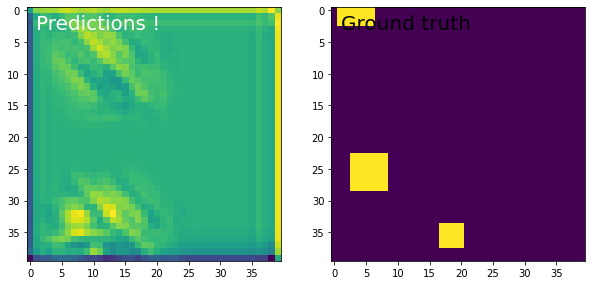

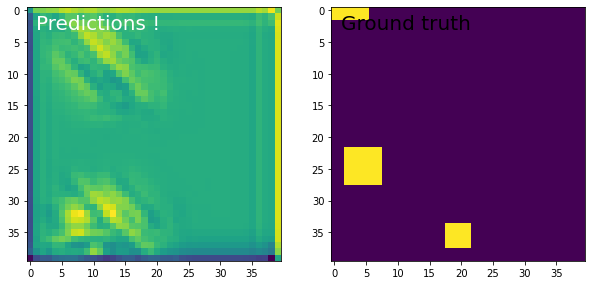

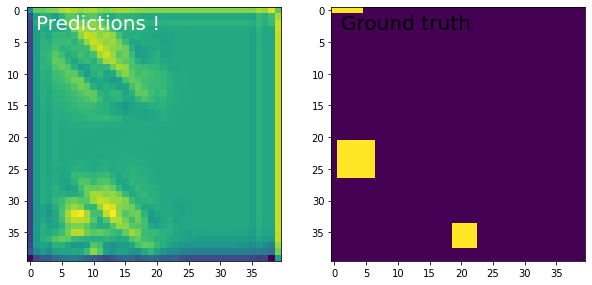

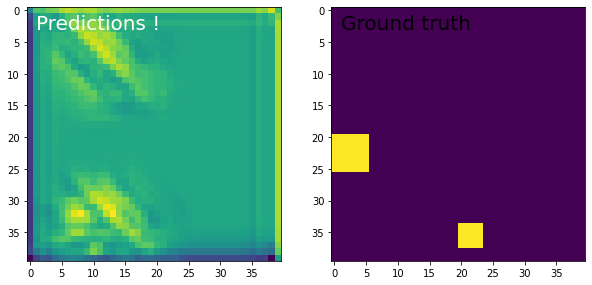

In [5]:
movie_index = 1004
track = noisy_movies[movie_index][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig("%i_animate.png" % (i + 1))


# WedgeDropoutLSTM2D

In [6]:
!pip uninstall -y keras-wedge-dropout
!pip install -q git+https://github.com/LanceNorskog/keras-wedge.git
from keras_wedge_dropout import WedgeDropout3D, WedgeDropoutLSTM2D

In [7]:
seq_wedge = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        # WedgeDropout3D(similarity=0.8, batchwise=True),
        WedgeDropoutLSTM2D(similarity=0.65, batchwise=True),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
opt = keras.optimizers.Adadelta(learning_rate=0.001) # lower this
seq_wedge.compile(loss="binary_crossentropy", optimizer=opt, metrics=['acc'])


In [ ]:
epochs = 5000
tf.random.set_seed(42)
earlystopping = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True) #, min_delta=1e-4)

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
history = seq_wedge.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=30,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
    callbacks=[earlystopping]
)
print('Eval validation:', history.history['val_loss'][-patience], history.history['val_acc'][-patience])

Epoch 1/5000
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
30/30 - 48s - loss: 0.8008 - acc: 0.5420 - val_loss: 0.7118 - val_acc: 0.0564
Epoch 2/5000
30/30 - 26s - loss: 0.7894 - acc: 0.5582 - val_loss: 0.7356 - val_acc: 0.0562
Epoch 3/5000
30/30 - 26s - loss: 0.7754 - acc: 0.5742 - val_loss: 0.7636 - val_acc: 0.0563
Epoch 4/5000
30/30 - 26s - loss: 0.7791 - acc: 0.5589 - val_loss: 0.7965 - val_acc: 0.0568
Epoch 5/5000
30/30 - 26s - loss: 0.7542 - acc: 0.5977 - val_loss: 0.8297 - val_acc: 0.0578
Epoch 6/5000
30/30 - 26s - loss: 0.7529 - acc: 0.5929 - val_loss: 0.8605 - val_acc: 0.0606
Epoch 7/5000
30/30 - 26s - loss: 0.7458 - acc: 0.5928 - val_loss: 0.8839 - val_acc: 0.0664
Epoch 8/5000
30/30 - 26s - loss: 0.7459 - acc: 0.5941 - val_loss: 0.8941 - val_acc: 0.0805
Epoch 9/5000
30/30 - 26s - loss: 0.7366 - acc: 0.5917 - val_loss: 0.8894 - val_acc: 0.1053
Epoch 10/5000
30/30 - 26s - loss: 0.7369 - 

In [ ]:
print('Eval validation:', history.history['val_loss'][-patience], history.history['val_acc'][-patience])

In [ ]:
movie_index = 1004
track = noisy_movies[movie_index][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq_wedge.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig("%i_animate.png" % (i + 1))
